_В домашнем задании, будем обучать разные алгоритмы машинного обучения. Для этого, нужно предварительно зафиксировать схему валидации решения (можете выбрать любую, которую знаете). Выбранную схему валидации нужно использовать во всех задачах этого домашнего задания. Метрика качества_ - __ROC AUC__, _целевая переменная_ - __isFraud.__

__Ссылка на наборы данных:__ https://drive.google.com/file/d/1gMEVl47pIoV1-AseB9doQ6DZNJrY3NkW/view?usp=sharing

__Задание 1:__ _отобрать только числовые признаки и обучить модель XGBoost с параметром booster = gbtree. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно)._

In [1]:
# !conda install -c anaconda py-xgboost -y 1>nul
# !conda install lightgbm -y 1>nul
# !conda install catboost -y 1>nul

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [3]:
train = pd.read_csv("data/assignment_2_train.csv")
test = pd.read_csv("data/assignment_2_test.csv")

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 180000 rows, 394 cols
test.shape = 100001 rows, 394 cols


In [4]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
target = "isFraud"
numerical_features = train.select_dtypes(include=[np.number]).drop(columns=target).columns

In [6]:
train[target].unique()

array([0, 1], dtype=int64)

In [7]:
train_t, train_v = train_test_split(train, train_size=0.8, random_state=27)

In [8]:
params_xg = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": -1,
    "seed": 27
}

In [9]:
dtrain = xgb.DMatrix(data=train_t[numerical_features], label=train_t[target])
dvalid = xgb.DMatrix(data=train_v[numerical_features], label=train_v[target])
dtest = xgb.DMatrix(data=test[numerical_features])

In [10]:
model_xgb = xgb.train(
    params=params_xg,
    dtrain=dtrain,
    num_boost_round=200,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.651834	valid-auc:0.642258
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.797982	valid-auc:0.787411
[20]	train-auc:0.840269	valid-auc:0.827931
[30]	train-auc:0.860651	valid-auc:0.848945
[40]	train-auc:0.87435	valid-auc:0.862072
[50]	train-auc:0.884591	valid-auc:0.872579
[60]	train-auc:0.889982	valid-auc:0.877982
[70]	train-auc:0.893251	valid-auc:0.880568
[80]	train-auc:0.896344	valid-auc:0.883633
[90]	train-auc:0.898297	valid-auc:0.885359
[100]	train-auc:0.900821	valid-auc:0.887275
[110]	train-auc:0.902068	valid-auc:0.888392
[120]	train-auc:0.904053	valid-auc:0.890421
[130]	train-auc:0.905675	valid-auc:0.891726
[140]	train-auc:0.907154	valid-auc:0.89296
[150]	train-auc:0.907976	valid-auc:0.893667
Stopping. Best iteration:
[146]	train-auc:0.907976	valid-auc:0.893667



In [11]:
prob_xgb_test = model_xgb.predict(dtest)
prob_xgb_train = model_xgb.predict(xgb.DMatrix(data=train[numerical_features]))

__Задание 2:__ _обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 1._

In [12]:
df = pd.concat([train, test], keys=['train', 'test'])
df = pd.get_dummies(df)

train_cat, test_cat = df.loc['train'], df.loc['test']

print("train_cat.shape = {} rows, {} cols".format(*train_cat.shape))
print("test_cat.shape = {} rows, {} cols".format(*test_cat.shape))

del df

train_cat.shape = 180000 rows, 531 cols
test_cat.shape = 100001 rows, 531 cols


In [13]:
train_cat_t, train_cat_v = train_test_split(train_cat, train_size=0.8, random_state=27)

In [14]:
dtrain = xgb.DMatrix(data=train_cat_t.drop(columns=target), label=train_cat_t[target])
dvalid = xgb.DMatrix(data=train_cat_v.drop(columns=target), label=train_cat_v[target])
dtest = xgb.DMatrix(data=test_cat.drop(columns=target))

In [15]:
model_xgb_cat = xgb.train(
    params=params_xg,
    dtrain=dtrain,
    num_boost_round=200,
    early_stopping_rounds=10,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.651834	valid-auc:0.642258
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 10 rounds.
[10]	train-auc:0.797982	valid-auc:0.787411
[20]	train-auc:0.840392	valid-auc:0.827969
[30]	train-auc:0.867926	valid-auc:0.85165
[40]	train-auc:0.879173	valid-auc:0.862829
[50]	train-auc:0.887798	valid-auc:0.873956
[60]	train-auc:0.895807	valid-auc:0.880623
[70]	train-auc:0.900227	valid-auc:0.885348
[80]	train-auc:0.903824	valid-auc:0.888861
[90]	train-auc:0.907184	valid-auc:0.89241
[100]	train-auc:0.909826	valid-auc:0.895005
[110]	train-auc:0.911952	valid-auc:0.896791
[120]	train-auc:0.913407	valid-auc:0.898228
[130]	train-auc:0.915015	valid-auc:0.899843
[140]	train-auc:0.916161	valid-auc:0.901062
[150]	train-auc:0.917218	valid-auc:0.902031
[160]	train-auc:0.917927	valid-auc:0.902872
[170]	train-auc:0.917927	valid-auc:0.902872
Stopping. Best iteration:
[160]	train-auc:0.917927	valid-auc:0.902872



In [16]:
prob_xgb_test_cat = model_xgb_cat.predict(dtest)
prob_xgb_train_cat = model_xgb_cat.predict(xgb.DMatrix(data=train_cat.drop(columns=target)))

__Задание 3:__ _для числовых признаков обучить модель LightGBM. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно)._

In [17]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.01,
    "n_jobs": -1,
    "seed": 27
}

In [18]:
dtrain = lgb.Dataset(data=train_t[numerical_features], label=train_t[target])
dvalid = lgb.Dataset(data=train_v[numerical_features], label=train_v[target])

In [19]:
model_lgb = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    early_stopping_rounds=10,
    verbose_eval=10
)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.836	valid_1's auc: 0.822557
[20]	training's auc: 0.842554	valid_1's auc: 0.827031
[30]	training's auc: 0.868723	valid_1's auc: 0.856371
[40]	training's auc: 0.875003	valid_1's auc: 0.86144
[50]	training's auc: 0.877611	valid_1's auc: 0.863072
[60]	training's auc: 0.882756	valid_1's auc: 0.868745
[70]	training's auc: 0.885062	valid_1's auc: 0.870285
[80]	training's auc: 0.887569	valid_1's auc: 0.872375
[90]	training's auc: 0.88994	valid_1's auc: 0.874315
[100]	training's auc: 0.891508	valid_1's auc: 0.876623
[110]	training's auc: 0.893195	valid_1's auc: 0.877729
[120]	training's auc: 0.896227	valid_1's auc: 0.880038
[130]	training's auc: 0.899981	valid_1's auc: 0.885096
[140]	training's auc: 0.902755	valid_1's auc: 0.885953
[150]	training's auc: 0.905801	valid_1's auc: 0.888694
[160]	training's auc: 0.907257	valid_1's auc: 0.89012
[170]	training's auc: 0.90828	valid_1's auc: 0.890909
[180]	training's auc

In [20]:
prob_lgb_test = model_lgb.predict(test[numerical_features])
prob_lgb_train = model_lgb.predict(train[numerical_features])

__Задание 4:__ _обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 3._

In [21]:
dtrain = lgb.Dataset(data=train_cat_t.drop(columns=target), label=train_cat_t[target])
dvalid = lgb.Dataset(data=train_cat_v.drop(columns=target), label=train_cat_v[target])

In [22]:
model_lgb_cat = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    early_stopping_rounds=10,
    verbose_eval=10
)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.836265	valid_1's auc: 0.822764
[20]	training's auc: 0.842238	valid_1's auc: 0.827382
[30]	training's auc: 0.869639	valid_1's auc: 0.857145
[40]	training's auc: 0.87672	valid_1's auc: 0.861964
[50]	training's auc: 0.87954	valid_1's auc: 0.864518
[60]	training's auc: 0.883105	valid_1's auc: 0.867492
[70]	training's auc: 0.891881	valid_1's auc: 0.87624
[80]	training's auc: 0.894601	valid_1's auc: 0.879395
[90]	training's auc: 0.89644	valid_1's auc: 0.880865
[100]	training's auc: 0.898426	valid_1's auc: 0.882613
[110]	training's auc: 0.900744	valid_1's auc: 0.884588
[120]	training's auc: 0.903951	valid_1's auc: 0.88721
[130]	training's auc: 0.906403	valid_1's auc: 0.888654
[140]	training's auc: 0.90869	valid_1's auc: 0.88977
[150]	training's auc: 0.910522	valid_1's auc: 0.891601
[160]	training's auc: 0.912706	valid_1's auc: 0.89253
[170]	training's auc: 0.914314	valid_1's auc: 0.893531
[180]	training's auc:

In [23]:
prob_lgb_test_cat = model_lgb.predict(test_cat.drop(columns=target))
prob_lgb_train_cat = model_lgb.predict(train_cat.drop(columns=target))

__Задание 5:__ _обработать категориальные признаки встроенным методом в LightGBM. Выполнить задание 3. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 4._

In [24]:
train_lgb = train.copy()
categorical_features = train.select_dtypes(exclude=[np.number]).columns
train_lgb[categorical_features] = train_lgb[categorical_features].astype('category')
categorical_indexes = list(map(lambda clmn: train.columns.get_loc(clmn), categorical_features))

In [25]:
train_t, train_v = train_test_split(train_lgb, train_size=0.8, random_state=27)

In [26]:
dtrain = lgb.Dataset(data=train_t.drop(columns=target), label=train_t[target], categorical_feature=categorical_indexes)
dvalid = lgb.Dataset(data=train_v.drop(columns=target), label=train_v[target], categorical_feature=categorical_indexes)

In [27]:
model_lgb_cat_s = lgb.train(
    params=params_lgb,
    train_set=dtrain,
    num_boost_round=200,
    valid_sets=[dtrain, dvalid],
    categorical_feature=categorical_indexes,
    early_stopping_rounds=10,
    verbose_eval=10
)

Training until validation scores don't improve for 10 rounds
[10]	training's auc: 0.856912	valid_1's auc: 0.831972
[20]	training's auc: 0.876133	valid_1's auc: 0.849368
[30]	training's auc: 0.884188	valid_1's auc: 0.855983
[40]	training's auc: 0.894242	valid_1's auc: 0.865001
[50]	training's auc: 0.902317	valid_1's auc: 0.870703
[60]	training's auc: 0.909159	valid_1's auc: 0.87481
[70]	training's auc: 0.916584	valid_1's auc: 0.881453
[80]	training's auc: 0.924493	valid_1's auc: 0.887666
[90]	training's auc: 0.928339	valid_1's auc: 0.890942
[100]	training's auc: 0.93136	valid_1's auc: 0.8943
[110]	training's auc: 0.934262	valid_1's auc: 0.897308
[120]	training's auc: 0.937798	valid_1's auc: 0.901337
[130]	training's auc: 0.940135	valid_1's auc: 0.903976
[140]	training's auc: 0.941916	valid_1's auc: 0.906114
[150]	training's auc: 0.943961	valid_1's auc: 0.908207
[160]	training's auc: 0.945815	valid_1's auc: 0.910373
[170]	training's auc: 0.947411	valid_1's auc: 0.911594
[180]	training's 

In [28]:
test_lgb = test.copy()
test_lgb[categorical_features] = test_lgb[categorical_features].astype('category')

In [29]:
prob_lgb_test_cat_s = model_lgb_cat_s.predict(test_lgb.drop(columns=target))
prob_lgb_train_cat_s = model_lgb_cat_s.predict(train_lgb.drop(columns=target))

Встроенный метод обработки категориальных признаков показал результаты лучше, чем собственная обработка.

__Задание 6:__ _для числовых признаков обучить модель CatBoost. Обучать алгоритм до тех пор, пока метрика качества не перестанет улучшаться на валидационной выборке в течение определенного числа итераций (выбрать значение самостоятельно)._

In [30]:
params_cb = {
    "n_estimators": 200,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 20,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 10,
    "thread_count": -1,
    "random_seed": 27
}

In [31]:
dtrain = cb.Pool(train_t[numerical_features], train_t[target])
dvalid = cb.Pool(train_v[numerical_features], train_v[target])

In [32]:
model_cb = cb.CatBoostClassifier(**params_cb)
model_cb.fit(dtrain, eval_set=dvalid);

0:	test: 0.6522772	best: 0.6522772 (0)	total: 167ms	remaining: 33.3s
10:	test: 0.8121119	best: 0.8121119 (10)	total: 752ms	remaining: 12.9s
20:	test: 0.8335283	best: 0.8335283 (20)	total: 1.34s	remaining: 11.5s
30:	test: 0.8420589	best: 0.8420589 (30)	total: 1.98s	remaining: 10.8s
40:	test: 0.8468986	best: 0.8468986 (40)	total: 2.58s	remaining: 10s
50:	test: 0.8485785	best: 0.8485785 (50)	total: 3.3s	remaining: 9.63s
60:	test: 0.8506012	best: 0.8506012 (60)	total: 3.93s	remaining: 8.96s
70:	test: 0.8530555	best: 0.8530555 (70)	total: 4.61s	remaining: 8.38s
80:	test: 0.8534536	best: 0.8534912 (79)	total: 5.32s	remaining: 7.82s
90:	test: 0.8559614	best: 0.8559614 (90)	total: 6.06s	remaining: 7.26s
100:	test: 0.8563892	best: 0.8563892 (100)	total: 6.74s	remaining: 6.6s
110:	test: 0.8561325	best: 0.8565797 (101)	total: 7.41s	remaining: 5.94s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8565797099
bestIteration = 101

Shrink model to first 102 iterations.


In [33]:
prob_cb_test = model_cb.predict(test[numerical_features], prediction_type='Probability')
prob_cb_train = model_cb.predict(train[numerical_features], prediction_type='Probability')

__Задание 7:__ _обработать категориальные признаки любым способом (который вы знаете) и добавить их к данным. Выполнить задание 6._

In [34]:
dtrain = cb.Pool(train_cat_t.drop(columns=target), train_cat_t[target])
dvalid = cb.Pool(train_cat_v.drop(columns=target), train_cat_v[target])

In [35]:
model_cb_cat = cb.CatBoostClassifier(**params_cb)
model_cb_cat.fit(dtrain, eval_set=dvalid);

0:	test: 0.6374457	best: 0.6374457 (0)	total: 77.2ms	remaining: 15.4s
10:	test: 0.8004530	best: 0.8005107 (8)	total: 694ms	remaining: 11.9s
20:	test: 0.8191355	best: 0.8191355 (20)	total: 1.34s	remaining: 11.4s
30:	test: 0.8387092	best: 0.8387092 (30)	total: 1.98s	remaining: 10.8s
40:	test: 0.8430484	best: 0.8432656 (38)	total: 2.58s	remaining: 10s
50:	test: 0.8446166	best: 0.8450503 (49)	total: 3.21s	remaining: 9.39s
60:	test: 0.8468696	best: 0.8469980 (58)	total: 3.95s	remaining: 9.01s
70:	test: 0.8496778	best: 0.8496778 (70)	total: 4.66s	remaining: 8.47s
80:	test: 0.8531033	best: 0.8532444 (79)	total: 5.37s	remaining: 7.89s
90:	test: 0.8576869	best: 0.8577662 (89)	total: 6.05s	remaining: 7.25s
100:	test: 0.8594310	best: 0.8594310 (100)	total: 6.69s	remaining: 6.56s
110:	test: 0.8612796	best: 0.8612796 (110)	total: 7.37s	remaining: 5.91s
120:	test: 0.8630826	best: 0.8630826 (120)	total: 8.03s	remaining: 5.24s
130:	test: 0.8648933	best: 0.8648933 (130)	total: 8.83s	remaining: 4.65s
14

In [36]:
prob_cb_test_cat = model_cb_cat.predict(test_cat.drop(columns=target), prediction_type='Probability')
prob_cb_train_cat = model_cb_cat.predict(train_cat.drop(columns=target), prediction_type='Probability')

__Задание 8:__ _обработать категориальные признаки встроенным методом в CatBoost. Выполнить задание 6. Сделать выводы о качестве работы алгоритма, по сравнению с пунктом 7._

In [37]:
train_cb = train.copy()
train_cb[categorical_features] = train_cb[categorical_features].astype(str)

In [38]:
train_t, train_v = train_test_split(train_cb, train_size=0.8, random_state=27)

In [39]:
dtrain = cb.Pool(train_t.drop(columns=target), train_t[target], cat_features=categorical_features)
dvalid = cb.Pool(train_v.drop(columns=target), train_v[target], cat_features=categorical_features)

In [40]:
model_cb_cat_s = cb.CatBoostClassifier(**params_cb)
model_cb_cat_s.fit(dtrain, eval_set=dvalid);

0:	test: 0.6392798	best: 0.6392798 (0)	total: 289ms	remaining: 57.6s
10:	test: 0.7456536	best: 0.7456536 (10)	total: 2.67s	remaining: 45.9s
20:	test: 0.8039022	best: 0.8039022 (20)	total: 5.2s	remaining: 44.3s
30:	test: 0.8318543	best: 0.8318543 (30)	total: 8.12s	remaining: 44.3s
40:	test: 0.8369441	best: 0.8369441 (40)	total: 10.9s	remaining: 42.1s
50:	test: 0.8411330	best: 0.8411330 (50)	total: 13.6s	remaining: 39.8s
60:	test: 0.8424278	best: 0.8426577 (58)	total: 16.1s	remaining: 36.7s
70:	test: 0.8502604	best: 0.8502604 (70)	total: 18.8s	remaining: 34.2s
80:	test: 0.8544332	best: 0.8546300 (79)	total: 21.5s	remaining: 31.6s
90:	test: 0.8567108	best: 0.8567698 (88)	total: 24.1s	remaining: 28.8s
100:	test: 0.8592502	best: 0.8592502 (100)	total: 27s	remaining: 26.5s
110:	test: 0.8612476	best: 0.8612476 (110)	total: 29.9s	remaining: 24s
120:	test: 0.8625469	best: 0.8627105 (119)	total: 32.6s	remaining: 21.3s
130:	test: 0.8643538	best: 0.8643538 (130)	total: 35.3s	remaining: 18.6s
140:	

In [41]:
test_cb = test.copy()
test_cb[categorical_features] = test_cb[categorical_features].astype(str)

In [42]:
prob_cb_test_cat_s = model_cb_cat_s.predict(test_cb.drop(columns=target), prediction_type='Probability')
prob_cb_train_cat_s = model_cb_cat_s.predict(train_cb.drop(columns=target), prediction_type='Probability')

Встроенный алгоритм показал результаты хуже, чем собственная обработка категориальных переменных, что может быть вызвано плохой предобработкой данных или малым количеством категориальных переменных.

__Задание 9:__ _построить ROC-кривую для всех построенных алгоритмов на обучающей и тестовой выборке. Сделать выводы о работе алгоритмов с точки зрения качества на тестовой выборке и с точки зрения переобучения._

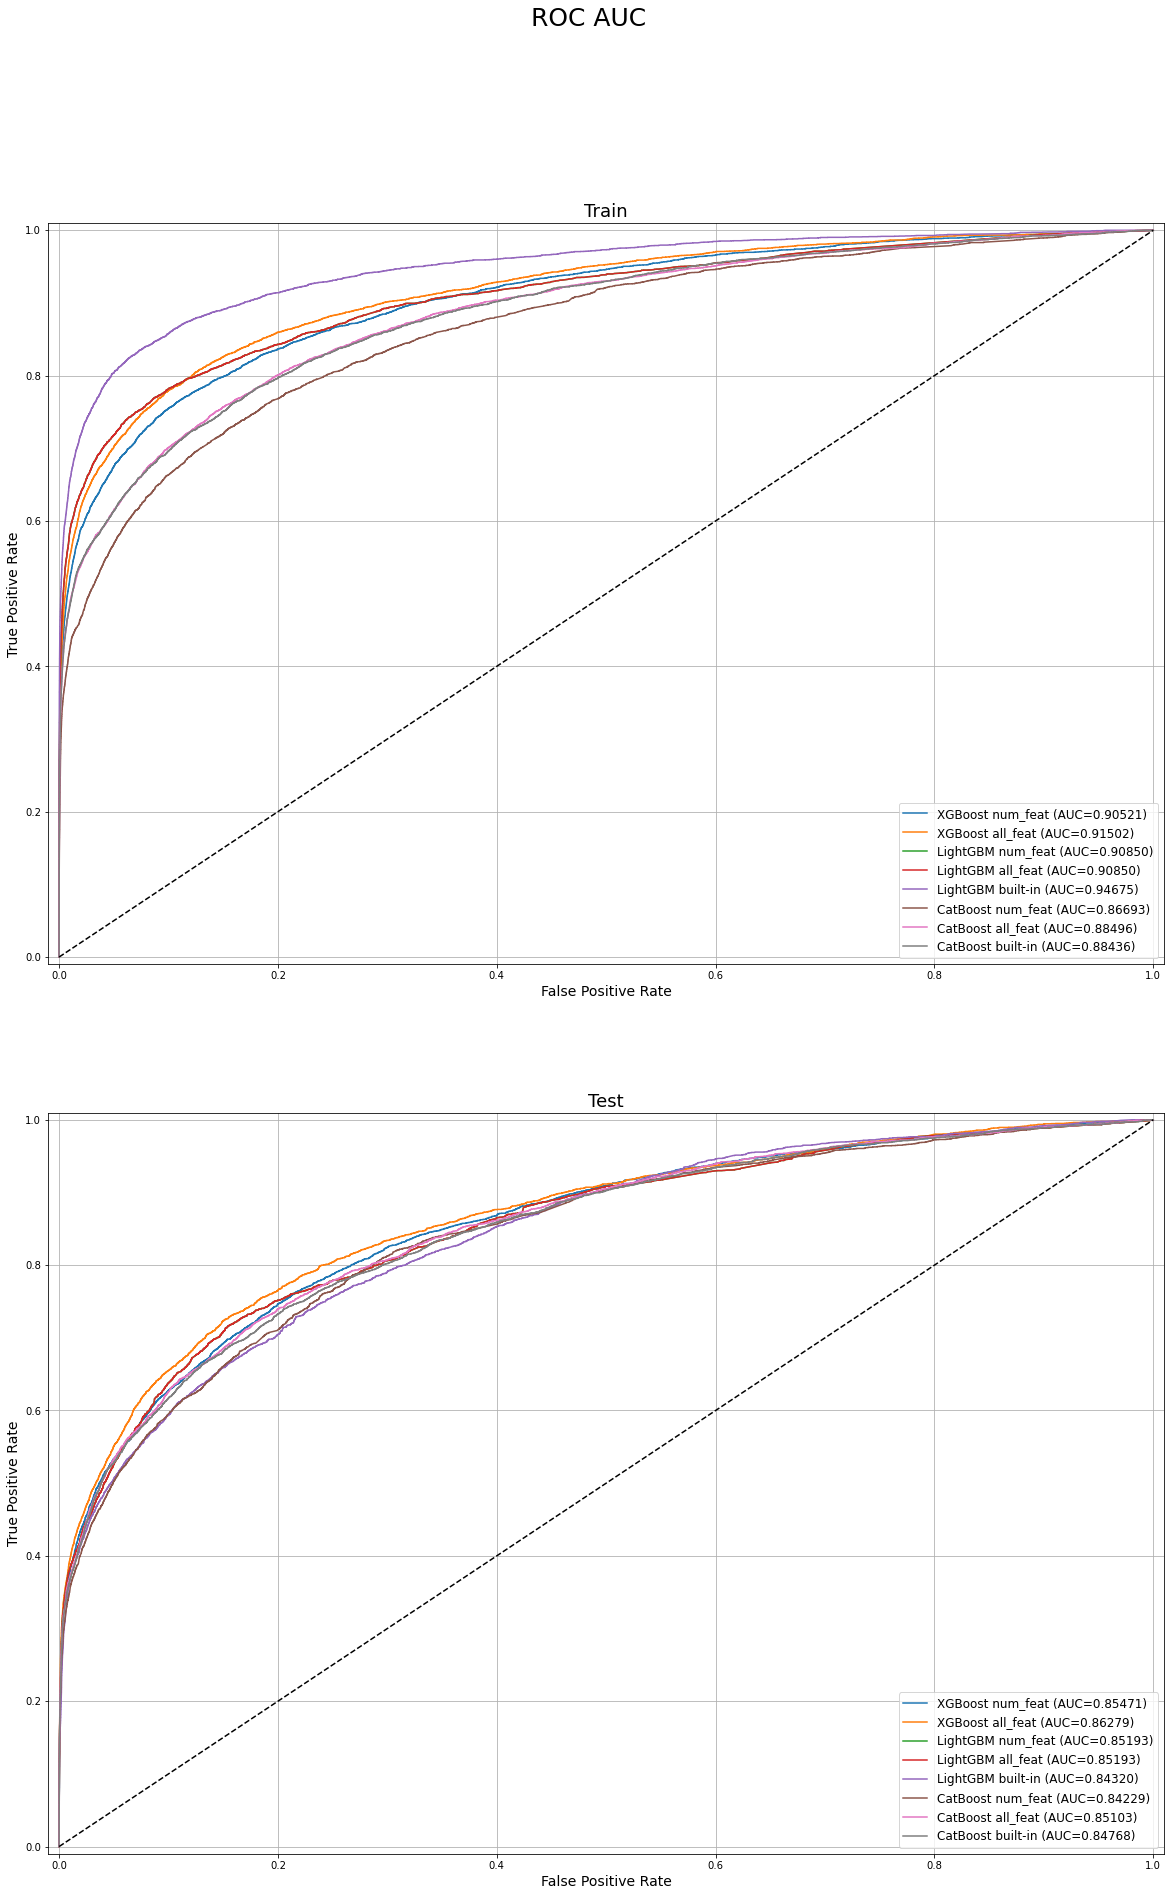

In [43]:
true_train = train[target].values
true_test = test[target].values

fig, axs = plt.subplots(2, 1, figsize=(20, 30))

fpr, tpr, _ = roc_curve(true_test, prob_xgb_test)
axs[1].plot(fpr, tpr, label=f'XGBoost num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_xgb_train)
axs[0].plot(fpr, tpr, label=f'XGBoost num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_xgb_test_cat)
axs[1].plot(fpr, tpr, label=f'XGBoost all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_xgb_train_cat)
axs[0].plot(fpr, tpr, label=f'XGBoost all_feat (AUC={auc(fpr, tpr):.5f})')


fpr, tpr, _ = roc_curve(true_test, prob_lgb_test)
axs[1].plot(fpr, tpr, label=f'LightGBM num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_lgb_train)
axs[0].plot(fpr, tpr, label=f'LightGBM num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_lgb_test_cat)
axs[1].plot(fpr, tpr, label=f'LightGBM all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_lgb_train_cat)
axs[0].plot(fpr, tpr, label=f'LightGBM all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_lgb_test_cat_s)
axs[1].plot(fpr, tpr, label=f'LightGBM built-in (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_lgb_train_cat_s)
axs[0].plot(fpr, tpr, label=f'LightGBM built-in (AUC={auc(fpr, tpr):.5f})')


fpr, tpr, _ = roc_curve(true_test, prob_cb_test[:, 1])
axs[1].plot(fpr, tpr, label=f'CatBoost num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_cb_train[:, 1])
axs[0].plot(fpr, tpr, label=f'CatBoost num_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_cb_test_cat[:, 1])
axs[1].plot(fpr, tpr, label=f'CatBoost all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_cb_train_cat[:, 1])
axs[0].plot(fpr, tpr, label=f'CatBoost all_feat (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_test, prob_cb_test_cat_s[:, 1])
axs[1].plot(fpr, tpr, label=f'CatBoost built-in (AUC={auc(fpr, tpr):.5f})')

fpr, tpr, _ = roc_curve(true_train, prob_cb_train_cat_s[:, 1])
axs[0].plot(fpr, tpr, label=f'CatBoost built-in (AUC={auc(fpr, tpr):.5f})')

for i in range(2):
    axs[i].plot([0, 1], [0, 1], 'k--')
    axs[i].set_xlim([-0.01, 1.01])
    axs[i].set_ylim([-0.01, 1.01])
    axs[i].set_xlabel('False Positive Rate', fontsize=14)
    axs[i].set_ylabel('True Positive Rate', fontsize=14)
    axs[i].grid()
    axs[i].legend(loc='lower right', fontsize='large')

axs[0].set_title('Train', fontsize=18)
axs[1].set_title('Test', fontsize=18)
fig.suptitle('ROC AUC', fontsize=25)
plt.show()

Все модели дают близкие результаты на тестовой выборке. Использование категориальных признаков в одних моделях дает небольшой прирост метрики AUC, в других - не дает результата. Правильная предобработка выборок и тонкая настройка гиперпараметров позволит улучшить качество модели и более эффективно использовать категориальные переменные для обучения.
По качеству на обучающей выборке видно, что XGBoost и LightGBM более подвержены переобчению, и использование категориальных признаков его усиливает. CatBoost более стабилен, хоть и показывает результаты немного ниже. Использование кросс валидации позволит снизить переобучение.

In [44]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Задание на повторение:__

__Задание 1:__ _Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи._

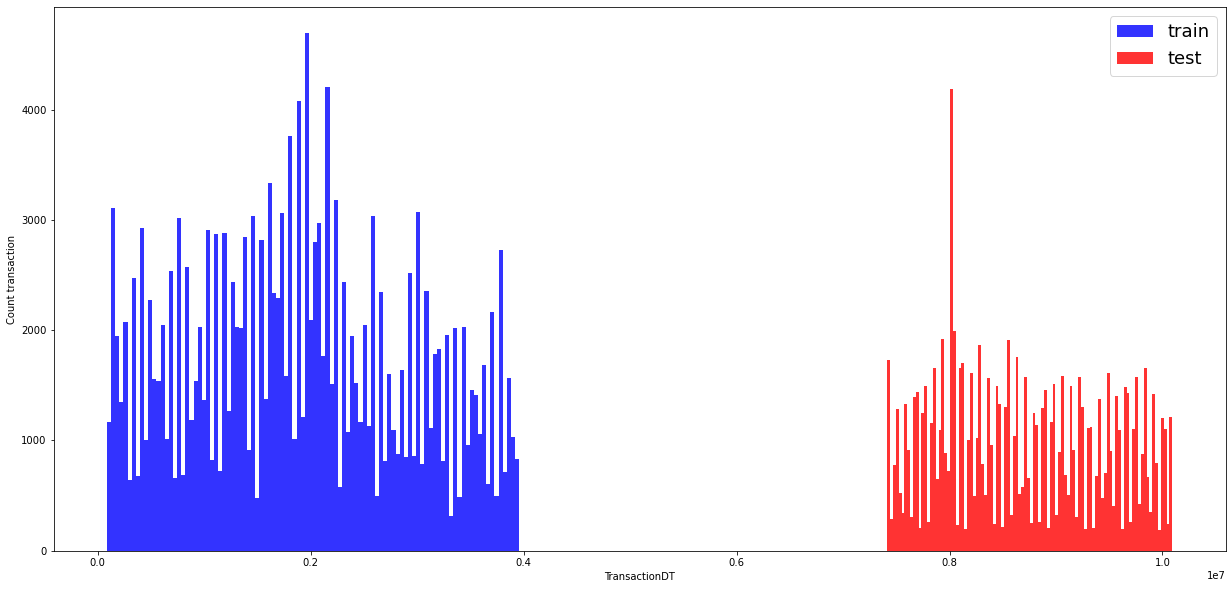

In [45]:
fig = plt.figure(figsize=(21, 10))

plt.hist(train["TransactionDT"], bins=100, color="blue", alpha=0.8, label="train")
plt.hist(test["TransactionDT"], bins=100, color="red", alpha=0.8, label="test")
plt.xlabel("TransactionDT")
plt.ylabel("Count transaction")
plt.legend(fontsize=18);

Данные представляют собой временные ряды и разбиты они по времени, причем train и test разнесены во времени. Для данной выборки подойдет cross-validation on a rolling basis.

__Задание 2:__ _построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы._

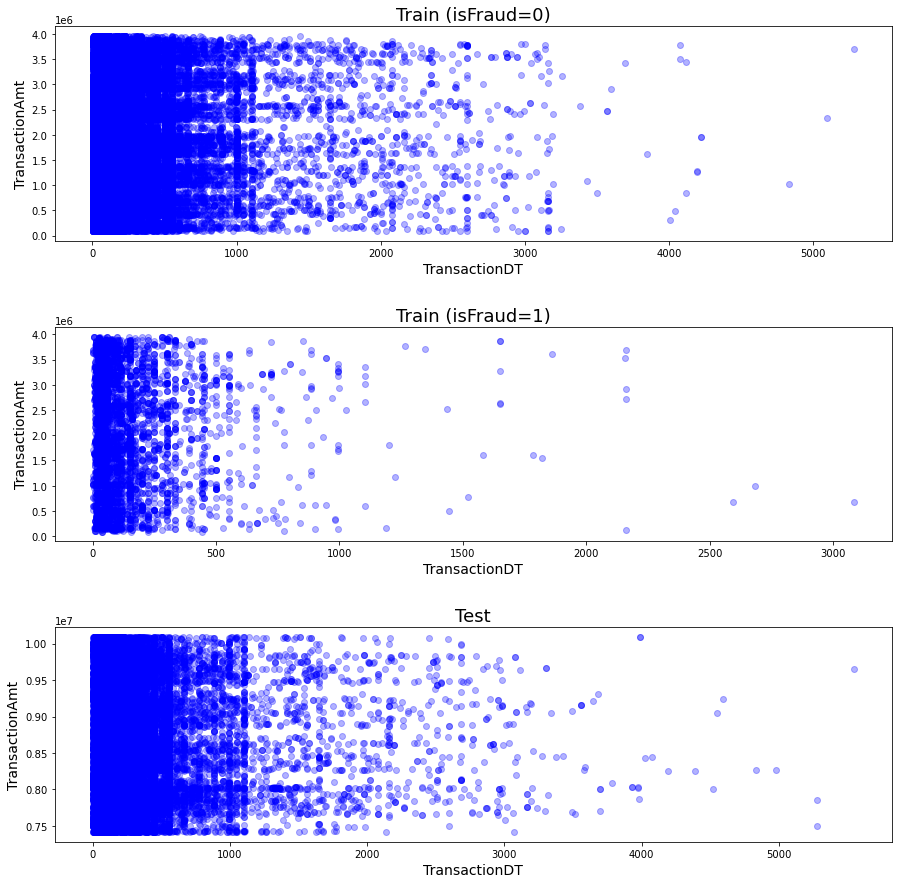

In [46]:
S_SIZE = None
ALPHA = 0.3

fig, axs = plt.subplots(3, 1, figsize=(15, 15))

axs[0].scatter(x=train[train["isFraud"]==0]["TransactionAmt"],
               y=train[train["isFraud"]==0]["TransactionDT"], 
               s=S_SIZE,
               alpha=ALPHA, 
               color="b", 
               label="isFraud=0")

axs[0].set_ylabel("TransactionAmt", size=14)
axs[0].set_xlabel("TransactionDT", size=14)
# axs[0].legend()
axs[0].set_title("Train (isFraud=0)", size=18)

axs[1].scatter(x=train[train["isFraud"]==1]["TransactionAmt"],
               y=train[train["isFraud"]==1]["TransactionDT"], 
               s=S_SIZE,
               alpha=ALPHA, 
               color="b", 
               label="isFraud=1")

axs[1].set_ylabel("TransactionAmt", size=14)
axs[1].set_xlabel("TransactionDT", size=14)
# axs[1].legend()
axs[1].set_title("Train (isFraud=1)", size=18)

axs[2].scatter(x=test["TransactionAmt"], y=test["TransactionDT"], s=S_SIZE, alpha=ALPHA, color="b")
axs[2].set_ylabel("TransactionAmt", size=14)
axs[2].set_xlabel("TransactionDT", size=14)
axs[2].set_title("Test", size=18)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

Зависимость суммы транзакции от времени ее совершения распределена не равномерно. Также наблюдается дисбаланс классов.

__Задание 3:__ _построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы._

In [47]:
import scipy.stats as st

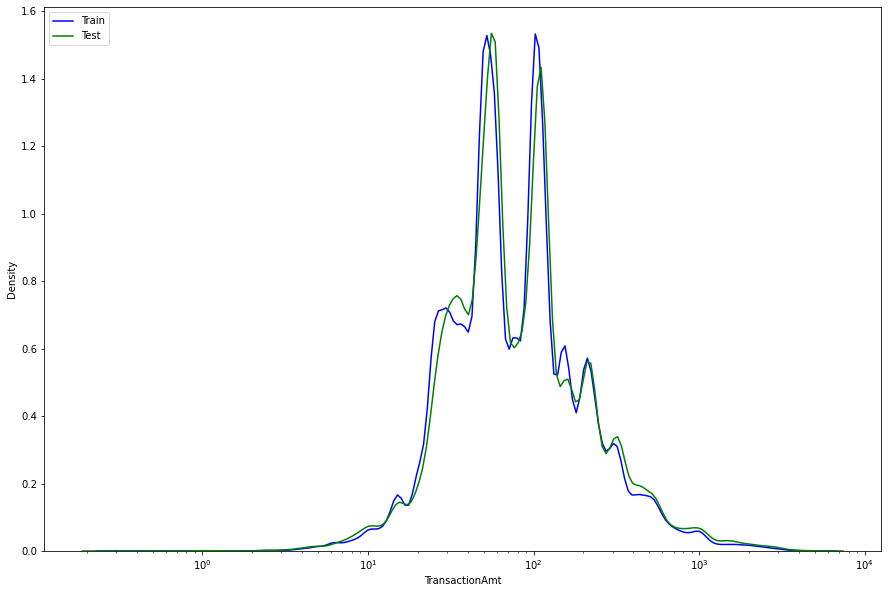

In [48]:
target_pl = "TransactionAmt"
fig = plt.figure(figsize=(15, 10))

sns.kdeplot(train[target_pl], color="blue", log_scale=True, label="Train")
sns.kdeplot(test[target_pl], color="green", log_scale=True, label="Test")
plt.legend(loc='upper left');

Распределения признака TransactionAmt для test и train близки, и они не распределены по нормальному закону.

__Задание 4:__ _построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы._

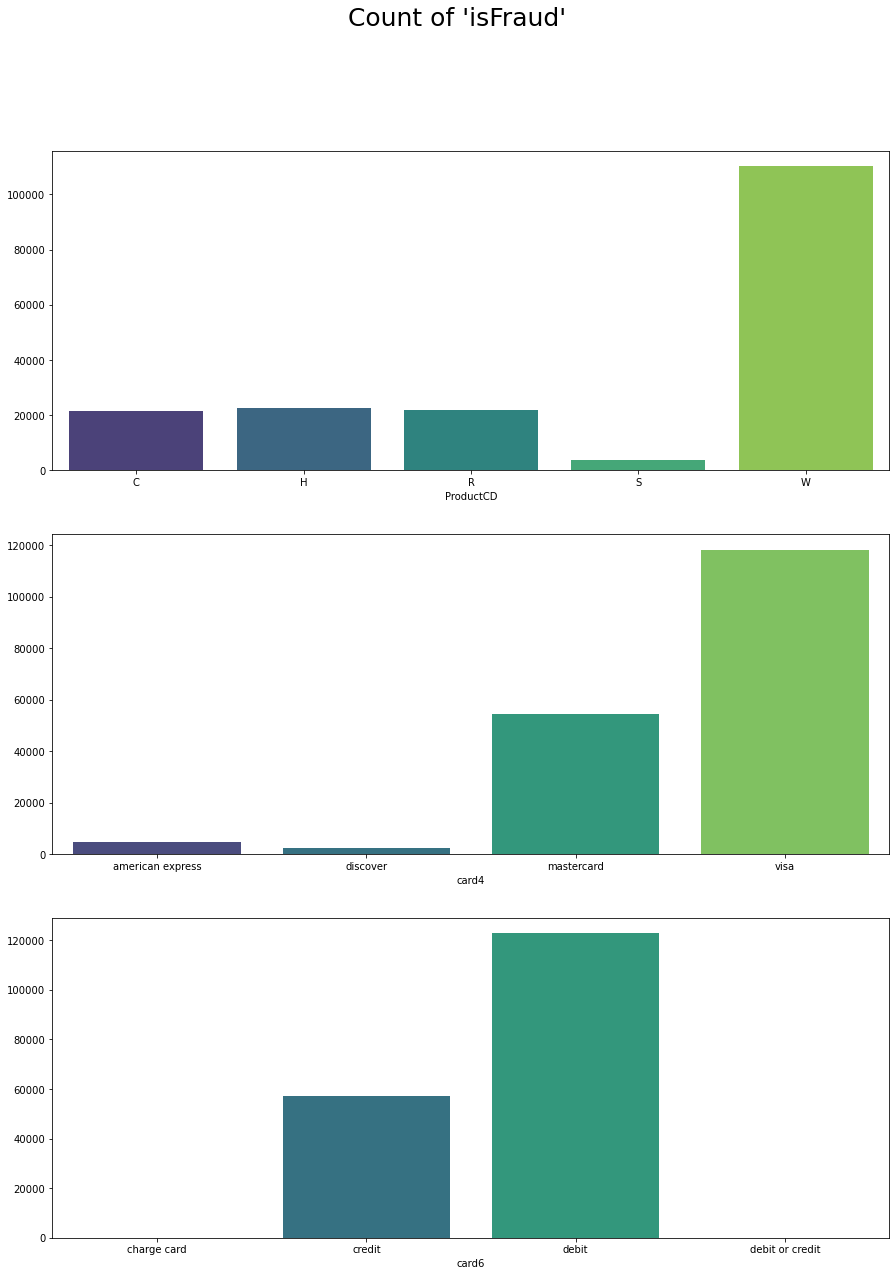

In [49]:
fig, axes = plt.subplots(3, 1, figsize=(15, 20))

for num, feature in enumerate(["ProductCD", "card4", "card6"]):
    data = train.copy()
    statistics = data.groupby([feature])["isFraud"].count()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num]
    )
fig.suptitle("Count of 'isFraud'", fontsize=25);

Наблюдается неравномерное распределение целевой переменной, в зависимости от значений категориальных признаков.